<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_5_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 6: Convolutional Neural Networks (CNN) for Computer Vision**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 6 Material

* Part 6.1: Image Processing in Python [[Video]](https://www.youtube.com/watch?v=4Bh3gqHkIgc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_06_1_python_images.ipynb)
* Part 6.2: Keras Neural Networks for Digits and Fashion MNIST [[Video]](https://www.youtube.com/watch?v=-SA8BmGvWYE&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_06_2_cnn.ipynb)
* Part 6.3: Implementing a ResNet in Keras [[Video]](https://www.youtube.com/watch?v=qMFKsMeE6fM&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_06_3_resnet.ipynb)
* Part 6.4: Using Your Own Images with Keras [[Video]](https://www.youtube.com/watch?v=VcFja1fUNSk&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_06_4_keras_images.ipynb)
* **Part 6.5: Recognizing Multiple Images with YOLO Darknet** [[Video]](https://www.youtube.com/watch?v=oQcAKvBFli8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_06_5_yolo.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.
  Running the following code will map your GDrive to ```/content/drive```.

In [6]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Mounted at /content/drive
Note: using Google CoLab


# Part 6.5: Recognizing Multiple Images with Darknet

Programmers typically design convolutional neural networks to classify a single item centered in an image.  However, as humans, we can recognize many items in our field of view in real-time.  It is advantageous to be able to recognize multiple items in a single image.  One of the most advanced means of doing this is YOLO DarkNet (not to be confused with the Internet [Darknet](https://en.wikipedia.org/wiki/Darknet).  YOLO [[Cite:redmon2016you]](https://arxiv.org/abs/1506.02640) is an acronym for You Only Look Once.  The fact that YOLO must only look once speaks to the efficiency of the algorithm.  In this context, to "look" means to perform one scan over the image. Figure 6.YOLO shows YOLO tagging in action.  It is also possible to run YOLO on live video streams.

**Figure 6.YOLO: YOLO Tagging**
![DarkNet](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/darknet-predictions.jpg "DarkNet")

As you can see, it is classifying many things in this video.  My collection of books behind me is adding considerable "noise," as DarkNet tries to classify every book behind me.  If you watch the video, you can see that it is less than perfect.  The coffee mug that I pick up gets classified as a cell phone and, at times, a remote.  The small yellow object behind me on the desk is a small toolbox (not a remote).  However, it gets classified as a book at times and a remote at other times.  Currently, this algorithm classifies each frame on its own.  The program could achieve greater accuracy if it analyzed multiple images from a video stream. Consider when you see an object coming towards you, if it changes angles, you might form a better opinion of what it was.  If that same object now changes to an unfavorable angle, you still know what it is, based on previous information.

### How Does DarkNet/YOLO Work?

YOLO begins by resizing the image to a $S \times S$ grid.  YOLO runs a  single convolutional neural network against this grid that predicts bounding boxes and what might be contained by those boxes.  Each bounding box also has a confidence in which item it believes the box contains.  YOLO is a regular convolution network, just like we've seen previously.  The only difference is that a YOLO CNN outputs multiple prediction bounding boxes. At a high level, Figure 6.YOLO-DET illustrates this.

**Figure 6.YOLO-DET: The YOLO Detection System**
![The YOLO Detection System](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/yolo-1.png "The YOLO Detection System")

The output of the YOLO convolutional neural networks is essentially a multiple regression.  YOLO generated the following values for each of the bounding rectangles.

* **x** - The x-coordinate of the center of a bounding rectangle.
* **y** - The y-coordinate of the center of a bounding rectangle.
* **w** - The width of each bounding rectangle.
* **h** - The height of each bounding rectangle.
* **labels** - The relative probabilities of each of the labels (1 value for each label)
* **confidence** - The confidence in this rectangle.

The output layer of a Keras neural network is a Tensor.  In the case of YOLO, this output tensor is 3D and is of the following dimensions.

$ S \times S \times (B \cdot 5 + C) $

The constants in the above expression are:

* *S* - The dimensions that YOLO overlays across the source image.
* *B* - The number of potential bounding rectangles generated for each grid cell.
* *C* - The number of class labels that here are.

The value 5 in the above expression is simply the count of non-label components of each bounding rectangle ($x$, $y$, $h$, $w$, $confidence$.

Because there are $S^2 \cdot B$ total potential bounding rectangles, the image is nearly full.  Because of this, it is essential to drop all rectangles below some threshold of confidence.  The image below demonstrates this.

The actual structure of the convolutional neural network behind YOLO is relatively simple, as the following figure illustrates.  Because there is only one convolutional neural network, and it "only looks once," the performance is not impacted by how many objects are detected.  Figure 6.YOLO-STRUCT shows the YOLO structure.

**Figure 6.YOLO-STRUCT: YOLO Structure**
![YOLO Structure](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/yolo-3.png "YOLO Structure")

### Using YOLO in Python

To make use of YOLO in Python, you have several options:

* **[DarkNet](https://pjreddie.com/darknet/yolo/)** - The original implementation of YOLO, written in C.
* **[yolov3-tf2](https://github.com/zzh8829/yolov3-tf2)** - An unofficial Python package that implements YOLO in Python, using TensorFlow 2.0.

The code provided in this notebook works equally well when run either locally or from Google CoLab.  In either case, the programmer should use TensorFlow 2.0.


### Installing YoloV3-TF2

YoloV3-TF2 is not available directly through either PIP or CONDA.  Additionally, YoloV3-TF2 is not installed in Google CoLab by default. Therefore, whether you wish to use YoloV3-TF2 through CoLab or run it locally, you need to go through several steps to install it.  This section describes the process of installing YoloV3-TF2.  The same steps apply to either CoLab or a local install.  For CoLab, you must repeat these steps each time the system restarts your virtual environment.  For a local install, you must perform these steps only once for your virtual Python environment.  If you are installing locally, make sure to install to the same virtual environment that you created for this course.  The following command installs YoloV3-TF2 directly from it's GitHub repository.

In [7]:
import sys

!{sys.executable} -m pip install \
  git+https://github.com/zzh8829/yolov3-tf2.git@master

  Cloning https://github.com/zzh8829/yolov3-tf2.git (to revision master) to /tmp/pip-req-build-bcb70l8j
  Running command git clone -q https://github.com/zzh8829/yolov3-tf2.git /tmp/pip-req-build-bcb70l8j
  Created wheel for yolov3-tf2: filename=yolov3_tf2-0.1-cp36-none-any.whl size=8851 sha256=3d89254e36656badd2bbc3929ede3fe71cb03caebc4a9e29ad8fc3c59873ad28
  Stored in directory: /tmp/pip-ephem-wheel-cache-i0gw2ne3/wheels/59/1b/97/905ab51e9c0330efe8c3c518aff17de4ee91100412cd6dd553
Successfully built yolov3-tf2


Before you can make use of YoloV3-TF2 there are several files you must obtain:

* **yolov3.weights** - These are the pre-trained weights provided by the author of YOLO.
* **convert.py** - This is a Python script that converts **yolov3.weights** into a TensorFlow compatible weight format.
* **coco.names** - The names of the 80 items that the **yolov3.weights** neural network was trained to recognize.
* **yolov3.tf** - The YOLO weights converted to a format that TensorFlow can use directly.

The code provided below obtains these files.  The script stores these files to either your GDrive, if you are using CoLab, or a local folder named "data" if you are running locally.

Researchers have trained YOLO on a variety of different computer image datasets.  The version of YOLO weights used in this course is from the dataset Common Objects in Context (COCO). [[Cite: lin2014microsoft]](https://arxiv.org/abs/1405.0312) This dataset contains images labeled into 80 different classes.  COCO is the source of the file coco.txt that used in this module.  

Developers have also adapted YOLO for mobile devices by creating the YOLO Tiny pre-trained weights that use a much smaller convolutional neural network and still achieve acceptable levels of quality.  Though YoloV3-TF2 can work with either YOLO Tiny or regular YOLO we are not using the tiny weights for this course.

In [8]:
import tensorflow as tf
import os

if COLAB:
  ROOT = '/content/drive/My Drive/projects/t81_558_dlearning/yolo'
else:
  ROOT = os.path.join(os.getcwd(),'data')

filename_darknet_weights = tf.keras.utils.get_file(
    os.path.join(ROOT,'yolov3.weights'),
    origin='https://pjreddie.com/media/files/yolov3.weights')
TINY = False

filename_convert_script = tf.keras.utils.get_file(
    os.path.join(os.getcwd(),'convert.py'),
    origin="https://raw.githubusercontent.com/zzh8829/"\
      "yolov3-tf2/master/convert.py")

filename_classes = tf.keras.utils.get_file(
    os.path.join(ROOT,'coco.names'),
    origin="https://raw.githubusercontent.com/zzh8829/"\
      "yolov3-tf2/master/data/coco.names")
filename_converted_weights = os.path.join(ROOT,'yolov3.tf')

### Transfering Weights

In the course, we transfer already trained weights into our YOLO networks.  It can take considerable time to train a YOLO network from scratch.  If you would like to train a YOLO network to recognize images other than the COLO provided images, then you may need to train your own YOLO information.  If training from scratch is something you need to do, there is further information on this at the YoloV3-TF2 GitHub repository.

The weights provided by the original authors of YOLO is not directly compatible with TensorFlow.  Because of this, it is necessary first to convert the YOLO provided weights into a TensorFlow compatible format. The following code does this conversion.  This process does not need to be repeated by the program. Once the conversion script processes YOLO weights the saved to the yolov3.tf YOLO can reuse these converted wights. The following code performs this conversion.

In [9]:
import sys
!{sys.executable} "{filename_convert_script}" --weights \
    "{filename_darknet_weights}" --output "{filename_converted_weights}"

2020-10-27 01:22:57.767882: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-10-27 01:22:59.851539: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-27 01:22:59.861952: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-10-27 01:22:59.862007: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fd7bab49958b): /proc/driver/nvidia/version does not exist
2020-10-27 01:22:59.897020: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2300000000 Hz
2020-10-27 01:22:59.897288: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x27bebc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-10-27 01:22:59.897327: I tensorflow/com

The conversion script is no longer needed once this script converts the YOLO weights have to a TensorFlow format.  Because this executable file resides in the same directory as the course files, we delete it at this point.

In [10]:
import os
os.remove(filename_convert_script)

Now that we have all of the files needed for YOLO, we are ready to use it to recognize components of an image.

### Running DarkFlow (YOLO)

The YoloV3-TF2 library can easily integrate with Python applications.  The initialization of the library consists of three steps.  First, it is essential to import all of the needed packages for the library.  Next, the Python program must define all of the YOLO configurations through the Keras flags architecture. The Keras flag system primarily works from the command line; however, it also allows configuration programmatically in an application.  For this example, we configure the package programmatically.  Finally, we must scan available devices so that our application takes advantage of any GPUs.   The following code performs all three of these steps.

In [11]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (YoloV3, YoloV3Tiny)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs
import sys
from PIL import Image, ImageFile
import requests

# Flags are used to define several options for YOLO.
flags.DEFINE_string('classes', filename_classes, 'path to classes file')
flags.DEFINE_string('weights', filename_converted_weights, \
                    'path to weights file')
flags.DEFINE_boolean('tiny', False, 'yolov3 or yolov3-tiny')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_string('tfrecord', None, 'tfrecord instead of image')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])

# Locate devices to run YOLO on (e.g. GPU)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

It is important to understand that Keras flags can only be defined once. If you are going to classify more than one image, make sure that you do not define the flags additional times.

The following code initializes a YoloV3-TF2 classification object.  The weights are loaded, and the object is ready for use as the **yolo** variable.  It is not necessary to reload the weights and obtain a new **yolo** variable for each classification.  

In [12]:
# This example does not use the "Tiny version"
if FLAGS.tiny:
    yolo = YoloV3Tiny(classes=FLAGS.num_classes)
else:
    yolo = YoloV3(classes=FLAGS.num_classes)

# Load weights and classes
yolo.load_weights(FLAGS.weights).expect_partial()
print('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('classes loaded')

weights loaded
classes loaded


Next, we obtain an image to classify. For this example, the program loads the image from a URL.  YoloV3-TF2 expects that the image is in the format of a Numpy array.  An image file, such as JPEG or PNG, is converted into this raw Numpy format by calling the TensorFlow **decode_image** function.  YoloV3-TF2 can obtain images from other sources, so long as the program first decodes them to raw Numpy format.  The following code obtains the image in this format.

In [13]:
# Read image to classify
url = "https://raw.githubusercontent.com/jeffheaton/"\
    "t81_558_deep_learning/master/images/cook.jpg"
response = requests.get(url)
img_raw = tf.image.decode_image(response.content, channels=3)

At this point, we can classify the image that was just loaded.  The program should preprocess the image so that it is the size expected by YoloV3-TF2.  Your program also sets the confidence threshold at this point.  Any sub-image recognized with confidence below this value is not returned by YOLO.

In [14]:
# Preprocess image
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence 
# level will be ignored.)
FLAGS.yolo_score_threshold = 0.5

# Recognize and report results
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print(f"Prediction time: {hms_string(t2 - t1)}")

Prediction time: 0:00:01.49


It is important to note that the **yolo** class instantiated here is a callable object, which means that it can fill the role of both an object and a function. Acting as a function, *yolo* returns three arrays named **boxes**, **scores**, and **classes** that are of the same length.  The function returns all sub-images found with a score above the minimum threshold.  Additionally, the **yolo** function returns an array named called **nums**. The first element of the **nums** array specifies how many sub-images YOLO found to be above the score threshold.

* **boxes** - The bounding boxes for each of the sub-images detected in the image sent to YOLO.
* **scores** - The confidence for each of the sub-images detected.
* **classes** - The string class names for each of the items.  These are COCO names such as "person" or "dog." 
* **nums** - The number of images above the threshold.

Your program should use these values to perform whatever actions you wish as a result of the input image.  The following code simply displays the images detected above the threshold.

In [15]:
print('detections:')
for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"\t{cls}, {score}, {box}")

detections:
	person, 0.9995920062065125, [0.31659663 0.10725147 0.6842674  0.74258995]
	dog, 0.9896981716156006, [0.51111007 0.5576949  0.933974   0.81879807]
	microwave, 0.9839580059051514, [0.00695178 0.08101549 0.27909747 0.28820014]
	oven, 0.938312292098999, [0.00773557 0.32521236 0.4232145  0.8336828 ]
	bottle, 0.8538913726806641, [0.73093545 0.23399046 0.76463544 0.32874534]
	bottle, 0.5538197755813599, [0.790116   0.26327905 0.8189085  0.3274593 ]


Your program should use these values to perform whatever actions you wish as a result of the input image.  The following code simply displays the images detected above the threshold.

YoloV3-TF2 includes a function named **draw_outputs** that allows the sub-image detections to visualized.  The following image shows the output of the draw_outputs function.  You might have first seen YOLO demonstrated as an image with boxes and labels around the sub-images. A program can produce this output with the arrays returned by the **yolo** function.

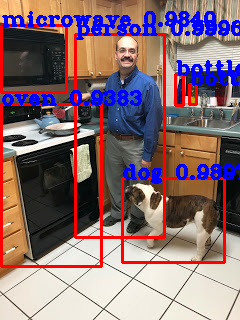

In [16]:
# Display image using YOLO library's built in function
img = img_raw.numpy()
img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
#cv2.imwrite(FLAGS.output, img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image

# Module 6 Assignment

You can find the first assignment here: [assignment 6](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/assignments/assignment_yourname_class6.ipynb)